# Build a neural network to classify MNIST by numpy

In [287]:
import numpy as np
import math
from pathlib import Path
import struct
import matplotlib.pyplot as plt

np.random.seed(1)

Load Data: Load by your path not only MNIST dataset, you can choose any dataset suit for DNN

In [288]:
data_path = Path('./MNIST')
train_img_path = data_path/'train-images-idx3-ubyte'
train_lab_path = data_path/'train-labels-idx1-ubyte'
test_img_path = data_path/'t10k-images-idx3-ubyte'
test_lab_path = data_path/'t10k-labels-idx1-ubyte'

In [289]:
# Load image and labels

# For training convenient, we set number of train to 5000.
num_train = 5000
num_valid = 10000
num_test = 10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img = np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)
    train_img = tmp_img[:num_train]
    valid_img = tmp_img[num_train:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img = np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)

with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab = np.fromfile(f,dtype=np.uint8)
    train_lab = tmp_lab[:num_train]
    valid_lab = tmp_lab[num_train:]
    
with open(test_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_lab = np.fromfile(f,dtype=np.uint8)

In [290]:
def imgshow(dataset = 'train', index = 666):
    if dataset == 'train':
        print('Trainning set:')
        plt.imshow(train_img[index].reshape(28,28), cmap = 'gray')
        print(f'Label: {train_lab[index]}')
    elif dataset == 'val':
        print('Validation set:')
        plt.imshow(valid_img[index].reshape(28,28), cmap = 'gray')
        print(f'Label: {valid_lab[index]}')
    elif dataset == 'test':
        print('Test set:')
        plt.imshow(test_img[index].reshape(28,28), cmap = 'gray')
        print(f'Label: {test_lab[index]}')
    else:
        print(f'No {dataset} dataset')

Trainning set:
Label: 0


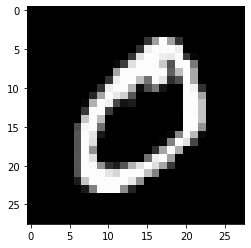

In [291]:
imgshow('train',1)

In [292]:
# Get the onehot encoding
onehot = np.identity(10)
onehot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Initial parameters

In [293]:

def para_shape(layer_dims):
    parameters_shape = []
    for i in range(1,len(layer_dims)):
        dict_para = {'b'+str(i):layer_dims[i], 'W'+str(i):[layer_dims[i],layer_dims[i-1]]}
        parameters_shape.append(dict_para)
    return parameters_shape

In [294]:
layer_dims = [5, 4, 3, 10] # input:28*28, layer1(output):10
layer_activations = ['tanh', 'tanh', 'softmax']
parameters_shape = para_shape(layer_dims)
parameters_shape

[{'b1': 4, 'W1': [4, 5]}, {'b2': 3, 'W2': [3, 4]}, {'b3': 10, 'W3': [10, 3]}]

In [295]:

def init_bias(b):
    return np.zeros(b).reshape(-1,1)

def init_weight(w):
#     Random initialization
#     return np.random.randn(w[0],w[1])  

#     Xavier initialization
#     return np.random.randn(w[0],w[1])*np.sqrt(2/w[1])

#     Random initialization within a small range
    return np.random.randn(w[0],w[1])*0.1

def init_parameters(para_shp):
    parameters = {}
    for i in range(1,len(para_shp)+1):
        para = {'b'+str(i):init_bias(para_shp[i-1]['b'+str(i)]), 'W'+str(i):init_weight(para_shp[i-1]['W'+str(i)])}
        parameters.update(para)
    return parameters


In [296]:
parameters = init_parameters(parameters_shape)
parameters

{'b1': array([[0.],
        [0.],
        [0.],
        [0.]]),
 'W1': array([[ 0.16243454, -0.06117564, -0.05281718, -0.10729686,  0.08654076],
        [-0.23015387,  0.17448118, -0.07612069,  0.03190391, -0.02493704],
        [ 0.14621079, -0.20601407, -0.03224172, -0.03840544,  0.11337694],
        [-0.10998913, -0.01724282, -0.08778584,  0.00422137,  0.05828152]]),
 'b2': array([[0.],
        [0.],
        [0.]]),
 'W2': array([[-0.11006192,  0.11447237,  0.09015907,  0.05024943],
        [ 0.09008559, -0.06837279, -0.01228902, -0.09357694],
        [-0.02678881,  0.05303555, -0.06916608, -0.03967535]]),
 'b3': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 'W3': array([[-0.06871727, -0.08452056, -0.06712461],
        [-0.00126646, -0.11173103,  0.02344157],
        [ 0.16598022,  0.07420442, -0.01918356],
        [-0.0887629 , -0.07471583,  0.16924546],
        [ 0.00508078, -0.06369956,

In [297]:
# check the parameters shape
parameters['W2'].shape

(3, 4)

In [298]:
# Activation function

def tanh(x):
    return np.tanh(x), x

def softmax(x):
    exp = np.exp(x-x.max())    # if we do not minus the x.max(), the result will be explode.
    return exp/exp.sum(axis=0, keepdims=True), x

def relu(x):
    return np.maximum(0,x), x

def Prelu(x):
    pass

def sigmoid(x):
    return 1/(1+np.exp(-x)), x

In [299]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W,A_prev) + b
    cache = (A_prev,W,b)    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    if activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == 'Prelu':
        pass
    elif activation == 'sigmoid':
        pass
    cache = (linear_cache, activation_cache)
    return A, cache

In [300]:
# forward pass
def model_forward(X, parameters, activations):

    caches = []
    A = X
    num_layers = len(parameters)//2
    
    for i in range(1,num_layers):
        A_prev = A
        W = parameters['W'+str(i)]
        b = parameters['b'+str(i)]
        A,cache = linear_activation_forward(A_prev, W, b, activations[i-1])
        caches.append(cache)
        
    Y_pred, cache = linear_activation_forward(A,parameters['W'+str(num_layers)],parameters['b'+str(num_layers)],activations[-1])
    caches.append(cache)
    
    return Y_pred, caches

In [301]:
# compute the cost
def compute_cost(Y_pred,Y_true):

    m = Y_true.shape[1]
    cost = -np.sum(Y_true*np.log(Y_pred))/m
    cost = np.squeeze(cost)
    
    return cost

In [302]:
def linear_backward(dZ, cache):
    A_prev,W,b = cache
    m = A_prev.shape[1]
    
    dW = (1/m)*np.dot(dZ,np.transpose(A_prev))
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(np.transpose(W),dZ)
    
    return dA_prev, dW, db


def activation_backward(dA, cache, activation):
#     print("linear_activation_backward")
    linear_cache, activation_cache = cache
    
    if activation == 'tanh':
        dZ = d_tanh(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == 'relu':
        dZ = d_relu(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == 'Prelu':
        dZ = d_relu(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == 'sigmoid':
        pass
    return dA_prev, dW, db

def last_layer_backprop(dA, Y_true, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'softmax':
        dZ = dA - Y_true
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == 'sigmoid':
        pass
    else:
        pass
    
    return dA_prev, dW, db

In [303]:
# back pass

def model_backward(Y_pred, Y_true, activations, caches):

    gradients = {}
    num_layers = len(caches)
    Y_true = Y_true.reshape(Y_pred.shape)
    
    dA = Y_pred 
    cur_cache = caches[-1]
    cur_activation = activations[-1]
    gradients["dA"+str(num_layers-1)],gradients["dW"+str(num_layers)],gradients["db"+str(num_layers)] = last_layer_backprop(dA, Y_true, cur_cache, cur_activation)

    for l in reversed(range(num_layers-1)):
        cur_cache = caches[l]
        cur_activation = activations[l]
        dA_prev_temp,dW_temp,db_temp = activation_backward(gradients["dA"+str(l+1)], cur_cache, cur_activation)
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp
        
    return gradients

In [304]:
# update parameter

def update_para(parameters,grads,learning_rate=0.001):

    num_layers = len(parameters)//2
    for l in range(num_layers):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters

In [305]:
# derivate of activation

def d_softmax(dA, Y_true, cache):
    dZ = dA - Y_true
    dZ = dZ/dZ.shape[1]
    return dZ

def d_tanh(dA, cache):
    Z = cache
    return 1 - np.tanh(dA)**2

def d_relu(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

def d_sigmoid(dA, cache):
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)    
    return dZ

def d_Prelu(dA,cache):
    pass

In [306]:
# build neu_net
def build_network(X,Y,layer_dims,layer_activations,num_iterations,learning_rate=0.01,print_cost=False):
    costs=[]
    # Initial parameters.
    parameter_shape = para_shape(layer_dims)
    parameters = init_parameters(parameter_shape)
    
    # Gradient descent
    for i in range(0, num_iterations):

        # Forward propagation: 
        Y_pred, caches = model_forward(X, parameters, layer_activations)

        # Compute cost.
        cost = compute_cost(Y_pred, Y)
    
        # Backward propagation:
        grads = model_backward(Y_pred, Y, layer_activations, caches)
#         break
        # Update parameters.
        parameters = update_para(parameters,grads,learning_rate=learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [307]:
onehot[train_lab].shape

(5000, 10)

Cost after iteration 0: 7.624379
Cost after iteration 100: 1.043654
Cost after iteration 200: 0.645908
Cost after iteration 300: 0.501640
Cost after iteration 400: 0.401322
Cost after iteration 500: 0.346719
Cost after iteration 600: 0.299721
Cost after iteration 700: 0.263745
Cost after iteration 800: 0.236090
Cost after iteration 900: 0.210043
Cost after iteration 1000: 0.189811
Cost after iteration 1100: 0.171249
Cost after iteration 1200: 0.155207
Cost after iteration 1300: 0.141475
Cost after iteration 1400: 0.127629
Cost after iteration 1500: 0.116170
Cost after iteration 1600: 0.106246
Cost after iteration 1700: 0.096596
Cost after iteration 1800: 0.088260
Cost after iteration 1900: 0.080703
Cost after iteration 2000: 0.074198
Cost after iteration 2100: 0.067810
Cost after iteration 2200: 0.062268
Cost after iteration 2300: 0.057102
Cost after iteration 2400: 0.052465


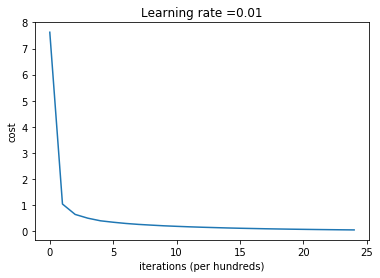

In [308]:
# Input 28*28, Output 10: Size depend on the dataset.
layers_dims = [28*28,30,20,10,10]
layer_activations = ['relu', 'relu','relu', 'softmax']

parameters = build_network(train_img.transpose(), onehot[train_lab].transpose(), layers_dims, layer_activations, num_iterations = 2500, print_cost = True)
